In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Input, Reshape, Flatten
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from mlflow import *
from mlflow.sklearn import *
from sklearn.feature_selection import SelectKBest, f_classif
from collections import Counter

# Set pandas options
pd.set_option('display.max_columns', 100)

# Define constants
RFC_METRIC = 'gini'
NUM_ESTIMATORS = 100
NO_JOBS = 4
VALID_SIZE = 0.20
TEST_SIZE = 0.20
NUMBER_KFOLDS = 5
RANDOM_STATE = 2018
MAX_ROUNDS = 1000
EARLY_STOP = 50
OPT_ROUNDS = 1000
VERBOSE_EVAL = 50
IS_LOCAL = False

In [2]:
import os
import sys
sys.path.append(os.path.join(os.path.abspath('..')))

In [ ]:
# Import modules
from src import data_loading as dl
from scripts.model_building_and_evaluation import *

In [4]:
# Load the dataset 
credit_card = dl.load_data('cleaned/creditcard_preprocessed.csv') # Loading credit card data

In [ ]:
print('No frouds', round(credit_card['Class'].value_counts()[0]/len(credit_card) * 100,2),
      '% of the dataset')
print('Frouds', round(credit_card['Class'].value_counts()[1]/len(credit_card) * 100,2),
      '% of the dataset')

No frouds 99.83 % of the dataset
Frouds 0.17 % of the dataset


**Overview**
In this phase, we’ll implement "Random Under-Sampling" to balance our dataset and prevent model overfitting.

**Steps:**
1. **Assess Class Imbalance:** Use value_counts() on the 'class' column to gauge the imbalance.

2. **Balancing Classes:** Equalize the number of fraud (Fraud = 1) and non-fraud (Fraud = 0) transactions. For a 50/50 ratio, match the number of non-fraud cases (283,253) to the number of fraud cases (473), resulting in 12,268 cases of each class.

3. **Shuffle Data:** Post balancing, shuffle the dataset to ensure consistent model performance across runs.

**Note:**
Random Under-Sampling might reduce the accuracy of our models due to significant information loss, as we're shrinking the dataset from 283253 non-fraudulent transactions to just 473. Therefore, while it ensures balance, it might impact the richness of the training data. 🚀📊✨

In [6]:
non_fraud_sum = credit_card[credit_card['Class'] == 0].value_counts().sum()
print(non_fraud_sum)

283253


In [7]:
fraud_sum = credit_card[credit_card['Class'] == 1].value_counts().sum()
print(fraud_sum)

473


In [8]:
# To address the class imbalance issue, we'll undersample the majority class
# to match the number of instances in the minority class.

# Randomly shuffle the entire dataset to ensure randomness
df = credit_card.sample(frac=1, random_state=42).reset_index(drop=True)

# Isolate the minority class (fraud) with 473 instances
minority_class = df.loc[df['Class'] == 1]

# Select a random subset of the majority class (non-fraud) with the same number of instances as the minority class
majority_class_subset = df.loc[df['Class'] == 0].sample(n=473, random_state=42)

# Combine the minority class and the majority class subset to create a balanced dataset
balanced_df = pd.concat([minority_class, majority_class_subset])

# Shuffle the balanced dataset to ensure randomness
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the first few rows of the balanced dataset
balanced_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.292032,-0.829907,-4.153014,8.204797,-15.031714,10.330100,-3.994426,-3.250013,-10.415698,4.620804,-5.711248,-11.797181,11.277921,-16.728339,0.241368,-17.721638,-0.387300,-10.322017,-13.959085,-5.030710,1.197266,1.412625,1.976988,0.256510,0.485908,-1.198821,-0.526567,0.634874,1.627209,0.723235,1
1,-0.292032,-0.345662,-5.753852,0.577610,-6.312782,5.159401,-1.698320,-2.683286,-7.934389,2.373550,-3.073079,-7.145137,6.250068,-9.150823,-1.376141,-9.982585,1.202217,-7.565042,-13.691474,-4.366867,2.181423,0.017500,1.177852,0.175331,-1.211123,-0.446891,-0.405520,-0.165797,1.505516,0.359492,1
2,-0.287999,-0.463192,1.257581,0.389792,0.316394,0.688601,-0.329816,-1.062477,0.117713,-0.230186,-0.037977,-0.296117,0.013473,0.482706,0.691512,-0.380290,1.042775,0.456562,-0.031831,-0.356491,-0.201463,-0.051933,-0.282539,-0.791483,0.124223,0.358095,0.232011,0.092895,-0.019934,0.031739,0
3,3.030594,-0.942854,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,1
4,-0.289529,0.720733,0.908637,2.849024,-5.647343,6.009415,0.216656,-2.397014,-1.819308,0.338527,-2.819883,-4.063098,2.941190,-6.151362,-1.989529,-9.150951,-0.604290,-1.952290,-2.892555,-0.912058,-1.563740,0.241921,0.407260,-0.397435,-0.080006,-0.168597,0.465058,0.210510,0.648705,0.360224,1


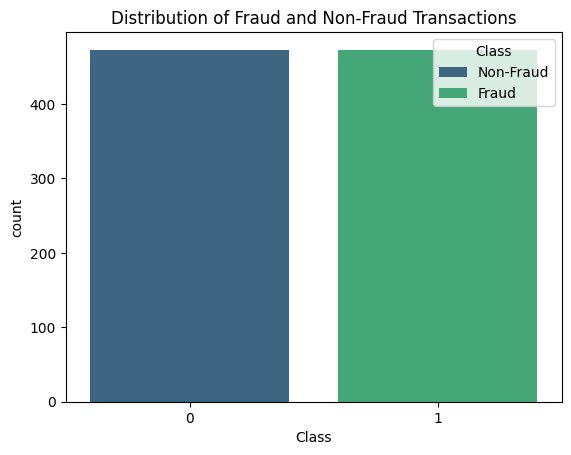

In [9]:
sns.countplot(data=balanced_df, x='Class', hue='Class', palette='viridis')
plt.legend(title='Class', labels=['Non-Fraud', 'Fraud'], loc='best')
plt.title('Distribution of Fraud and Non-Fraud Transactions')
plt.show()

Class            1.000000
V4               0.705040
V11              0.677543
V2               0.480987
V19              0.269217
V20              0.207444
V27              0.127747
V8               0.118733
V21              0.115103
V28              0.113086
scaled_amount    0.076941
V25              0.054909
V22              0.037749
V26              0.017372
V13             -0.009002
V15             -0.043194
V23             -0.044122
V24             -0.081138
scaled_time     -0.151169
V5              -0.353406
V6              -0.410617
V1              -0.415480
V18             -0.463647
V7              -0.467620
V17             -0.547633
V3              -0.562283
V9              -0.564377
V16             -0.586446
V10             -0.627000
V12             -0.674892
V14             -0.745788
Name: Class, dtype: float64


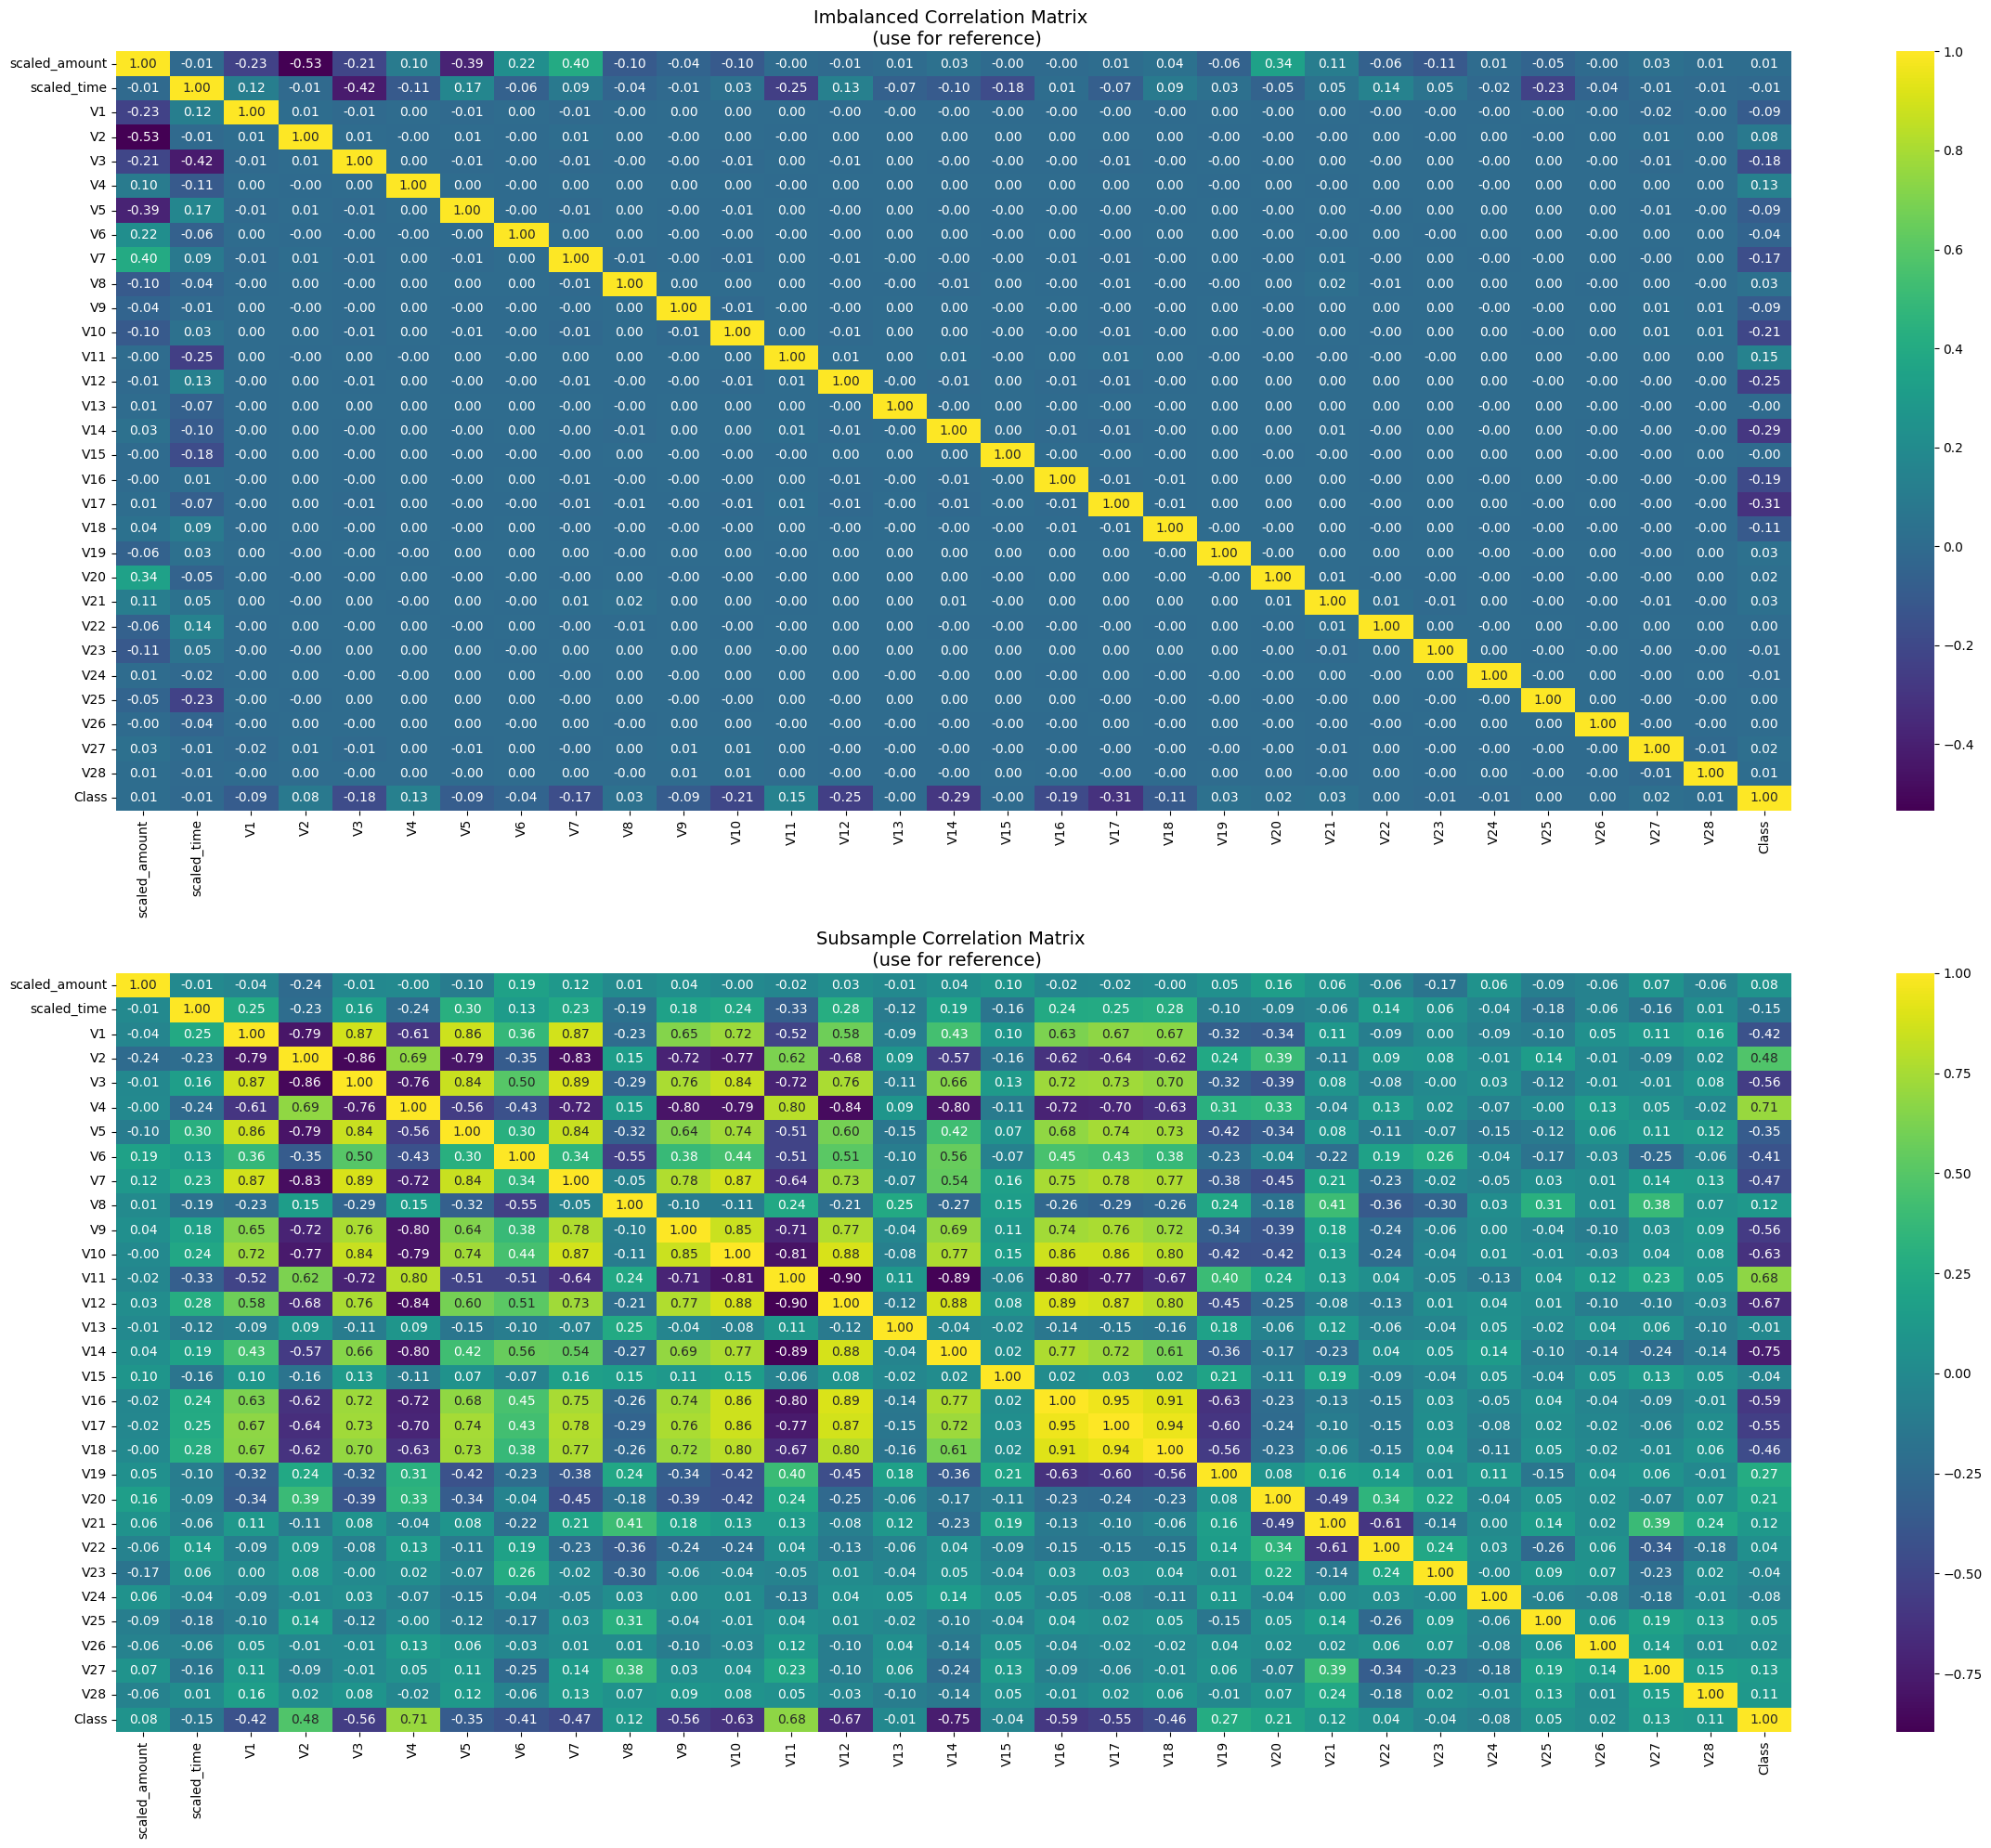

In [10]:
# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(24, 20))

# Calculate the correlation matrix for the imbalanced dataset
correlation_matrix_imbalanced = credit_card.corr(numeric_only=True)

# Calculate the correlation matrix for the balanced dataset
correlation_matrix_balanced = balanced_df.corr(numeric_only=True)

# Plot the correlation heatmap for the imbalanced dataset
sns.heatmap(correlation_matrix_imbalanced, ax=axes[0], cmap='viridis', annot=True, fmt=".2f")
axes[0].set_title('Imbalanced Correlation Matrix \n (use for reference)', fontsize=14)

# Plot the correlation heatmap for the balanced dataset
sns.heatmap(correlation_matrix_balanced, ax=axes[1], cmap='viridis', annot=True, fmt=".2f")
axes[1].set_title('Subsample Correlation Matrix \n (use for reference)', fontsize=14)

# Extract and sort correlations for the class column in the balanced dataset
class_corr = correlation_matrix_balanced['Class'].sort_values(ascending=False)
print(class_corr)

# Show the plots
plt.tight_layout()
plt.show()

#### After working with Random Under-Sampling i decided to try another method and that's because of this cons.
##### Cons of Random Under-Sampling:
- Information Loss: By drastically reducing the number of majority class instances, valuable information and patterns might be lost.

- Lower Model Performance: With fewer majority class samples, the model might not generalize well, leading to reduced accuracy.

- Bias Introduction: The randomly selected subset may not be representative of the entire majority class, potentially introducing bias.

- Overfitting Risk: The model might overfit to the limited majority class data, impacting its effectiveness on new data. 

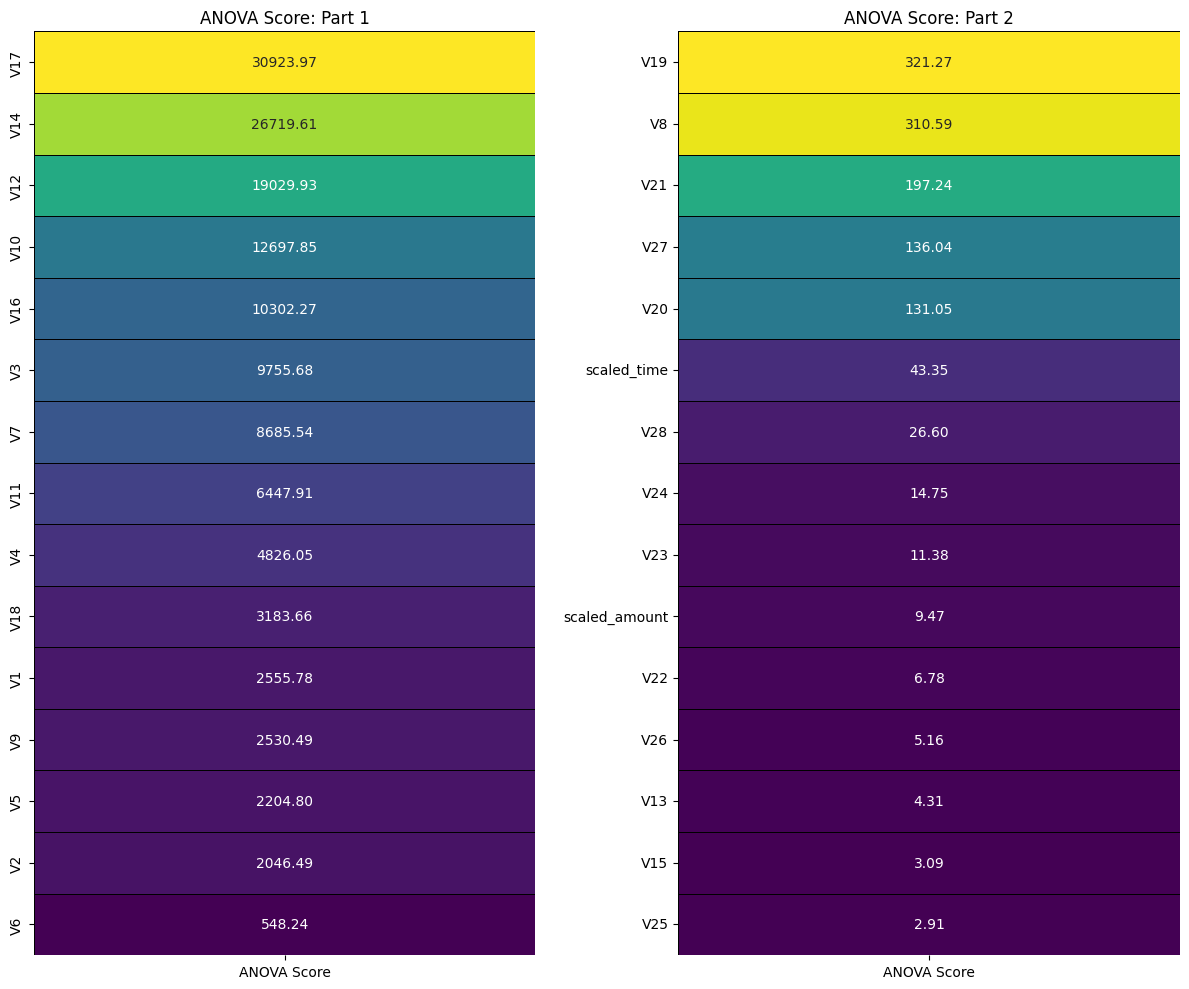

In [11]:
# Prepare features and target
features = credit_card.drop(columns=['Class'])
target = credit_card['Class']

# Select the best features using ANOVA
best_features = SelectKBest(score_func=f_classif, k='all')
fit = best_features.fit(features, target)
feature_scores = pd.DataFrame(data=fit.scores_, index=list(features.columns), columns=['ANOVA Score'])

# Sort the features by their ANOVA Score
feature_scores = feature_scores.sort_values(by='ANOVA Score', ascending=False)

# Plot the ANOVA scores using heatmap
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 10)) # Adjusted figsize for better visualization
plt.subplot(1, 2, 1)
sns.heatmap(feature_scores.iloc[:15, :], annot=True, cmap='viridis', linewidths=0.4, linecolor='black', cbar=False, fmt='.2f')
plt.title('ANOVA Score: Part 1')

plt.subplot(1, 2, 2)
sns.heatmap(feature_scores.iloc[15:30, :], annot=True, cmap='viridis', linewidths=0.4, linecolor='black', cbar=False, fmt='.2f')
plt.title('ANOVA Score: Part 2')

fig.tight_layout(w_pad=2)
plt.show()

In [12]:
df = credit_card.copy(deep = True)
df.drop(columns = list(feature_scores.index[20:]),inplace = True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V14,V16,V17,V18,V19,V20,V21,V27,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.133558,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.008983,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,-0.055353,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.062723,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.219422,0


#### Unbalanced Data:
When I have a dataset where one class far outweighs the others, I need to balance it to get accurate model results. Here are two common methods:

1. Undersampling: I reduce the number of instances in the dominant class.

2. Oversampling: I increase the number of instances in the minority class.

**Combining Both Methods**
For the best results, I use both techniques together. First, I reduce the instances in the majority class, then I increase the instances in the minority class to balance the dataset.

**Using Imbalanced-Learn**
To make this process easier, I use the imbalanced-learn library, which is tailored for balancing data. I can install it with:

> pip install imbalanced-learn

**Calculation for Data Balancing**
- **Sampling Strategy:** This ratio determines the balance between oversampling and undersampling.

**Example:**

- **Majority Class (No Fraud):** 283,253 samples

- **Minority Class (Fraud):** 493 samples

**Undersampling:**

- **Target Ratio:** 0.1

- **Majority Samples after Undersampling:** 4730 samples

**Oversampling:**

- **Target Ratio:** 0.5

- **Minority Samples after Oversampling:** 2365 samples

**Final Dataset:**

- **No Fraud:** 4730 samples

- **Fraud:** 2365 samples

**Why Use This Approach?**
For imbalanced datasets, using both undersampling and oversampling helps me create balanced data without introducing bias. This way, my model won't favor the majority class. Instead of relying on accuracy, I use metrics like the confusion matrix and ROC-AUC score to evaluate my model.

Ready to balance my dataset effectively and improve my model's performance!

In [13]:
# Define the resampling strategies
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.1)

# Split data into features (X) and target (y)
X = df.iloc[:, :20].values
y = df.iloc[:, 20].values

# Apply under-sampling first
X_under, y_under = under.fit_resample(X, y)

# Apply over-sampling on the under-sampled data
X_resampled, y_resampled = over.fit_resample(X_under, y_under)

# Now you can use the resampled data for further processing
print(Counter(y_resampled))

Counter({0: 4730, 1: 2365})


## Model Building and Evaluation

In [14]:
#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [15]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'MLP': MLPClassifier(max_iter=500),  # increase max_iter from 200 to 500
    'CNN': Sequential([
        Reshape((X_resampled.shape[1], 1)),
        Conv1D(32, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ]),
    'RNN': Sequential([
        Reshape((X_resampled.shape[1], 1)),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ]),
    'LSTM': Sequential([
        Reshape((X_resampled.shape[1], 1)),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
}

# Compile the models
for model_name, model in classifiers.items():
    if isinstance(model, Sequential):
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Evaluation Metrics

- I've evaluated the models using the following metrics:

1. **ROC-AUC Score:** a measure of the model's ability to distinguish between the positive and negative classes.
2. **Confusion Matrix:** a table that summarizes the model's predictions against the actual labels.

    **Actual Class vs. Predicted Class**

    * **True Negatives (Top-Left):** Correctly classified as "No" (No Fraud Detected)
    * **False Negatives (Top-Right):** Incorrectly classified as "No" (should be "Yes", Fraud Detected)
    * **False Positives (Bottom-Left):** Incorrectly classified as "Yes" (should be "No", No Fraud Detected)
    * **True Positives (Bottom-Right):** Correctly classified as "Yes" (Fraud Detected)

3. **Classification Report:** a report that provides precision, recall, and F1-score for each class.
4. **Cross-Validation Score:** a measure of the model's performance on unseen data.

### 1. Logistic Regression:
- a linear model that predicts the probability of a sample belonging to the positive class.

Logistic Regression
ROC_AUC Score :  98.56%


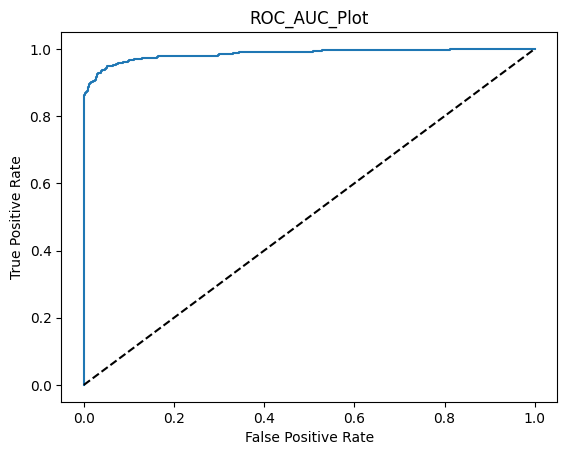

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       974
           1       0.97      0.89      0.93       445

    accuracy                           0.96      1419
   macro avg       0.96      0.94      0.95      1419
weighted avg       0.96      0.96      0.96      1419

Cross Validation Score:  98.54%




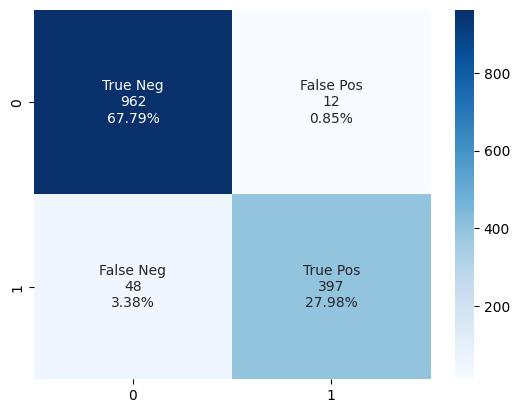

In [19]:
# Call each model separately
classifier = classifiers['Logistic Regression']
print("Logistic Regression")
model(classifier, X_train, y_train, X_test, y_test)
model_evaluation(classifier, X_test, y_test)
cross_validation_score(classifier, X_train, y_train)
print("\n")

### 2. Decision Tree: 
- a tree-based model that splits the data into subsets based on feature values.

Decision Tree
Cross Validation Score:  96.06%
ROC_AUC Score :  96.76%


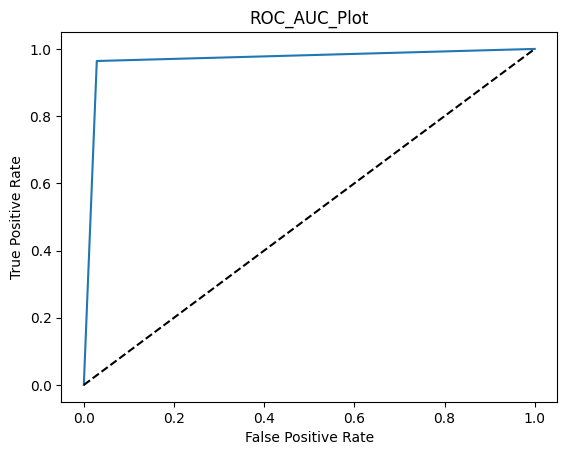

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       974
           1       0.94      0.96      0.95       445

    accuracy                           0.97      1419
   macro avg       0.96      0.97      0.96      1419
weighted avg       0.97      0.97      0.97      1419





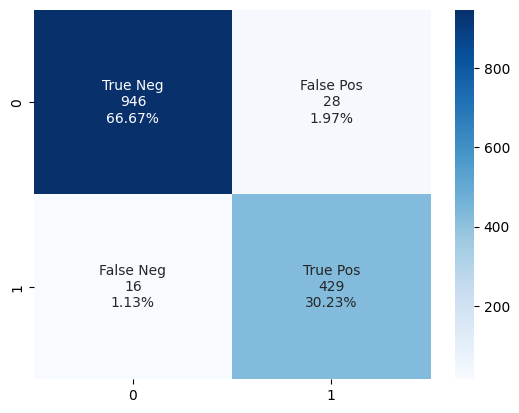

In [20]:
classifier = classifiers['Decision Tree']
print("Decision Tree")
cross_validation_score(classifier, X_train, y_train)
model(classifier, X_train, y_train, X_test, y_test)
model_evaluation(classifier, X_test, y_test)
print("\n")

### 3. Random Forest: 
- an ensemble model that combines multiple decision trees to improve performance.

Random Forest
Cross Validation Score :  99.77%
ROC_AUC Score :  99.95%


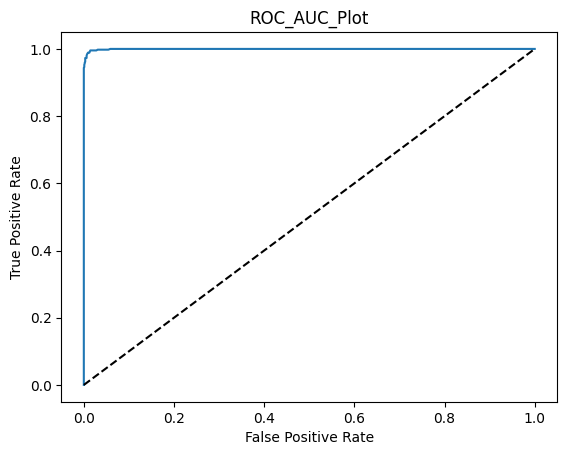

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       974
           1       0.99      0.97      0.98       445

    accuracy                           0.99      1419
   macro avg       0.99      0.98      0.99      1419
weighted avg       0.99      0.99      0.99      1419





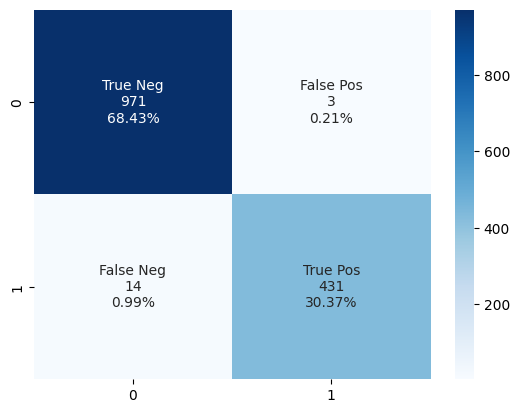

In [26]:
classifier = classifiers['Random Forest']
print("Random Forest")
cross_validation_score(classifier, X_train, y_train)
model(classifier, X_train, y_train, X_test, y_test)
model_evaluation(classifier, X_test, y_test)
print("\n")

### 4. Gradient Boosting: 
- an ensemble model that combines multiple weak models to create a strong model.

Gradient Boosting
Cross Validation Score :  99.38%
ROC_AUC Score :  99.66%


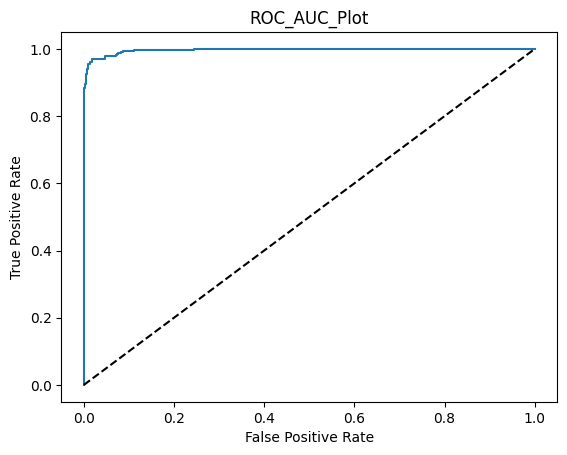

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       974
           1       0.99      0.93      0.95       445

    accuracy                           0.97      1419
   macro avg       0.98      0.96      0.97      1419
weighted avg       0.97      0.97      0.97      1419





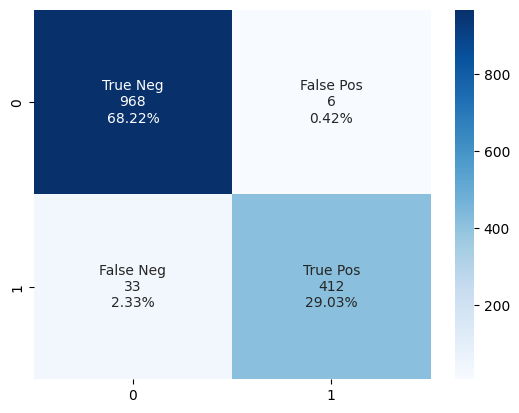

In [27]:
classifier_gb = classifiers['Gradient Boosting']
print("Gradient Boosting")
cross_validation_score(classifier_gb, X_train, y_train)
model(classifier_gb, X_train, y_train, X_test, y_test)
model_evaluation(classifier_gb, X_test, y_test)
print("\n")

### 5. MLP: 
- a neural network model with multiple layers.

MLP
Cross Validation Score:  99.90%
ROC_AUC Score :  99.74%


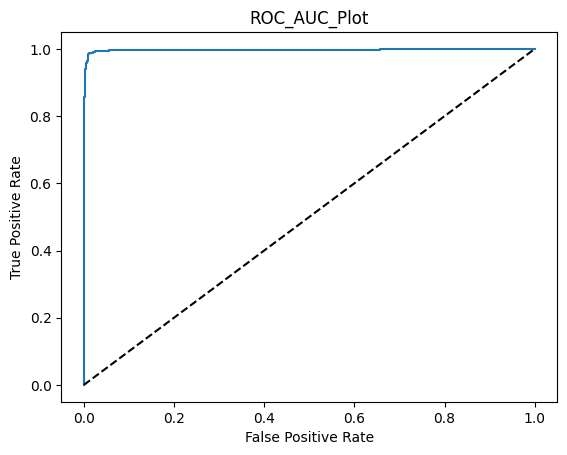

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       974
           1       0.96      0.99      0.98       445

    accuracy                           0.99      1419
   macro avg       0.98      0.99      0.98      1419
weighted avg       0.99      0.99      0.99      1419





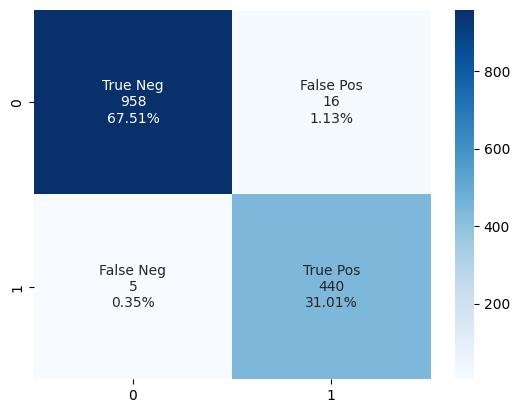

In [42]:
classifier_mlp = classifiers['MLP']
print("MLP")
cross_validation_score(classifier_mlp, X_train, y_train)
model(classifier_mlp, X_train, y_train, X_test, y_test)
model_evaluation(classifier_mlp, X_test, y_test)
print("\n")

### 6. CNN: 
- a convolutional neural network model designed for image classification.

CNN
Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9863 - loss: 0.0385
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9863 - loss: 0.0382
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9910 - loss: 0.0304
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9924 - loss: 0.0273
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9881 - loss: 0.0333
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9920 - loss: 0.0241
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9919 - loss: 0.0220
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9947 - loss: 0.0198
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9904 - loss: 0.0228
Epoch 10/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9950 - loss: 0.0178
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
ROC_AUC Score :  98.62%


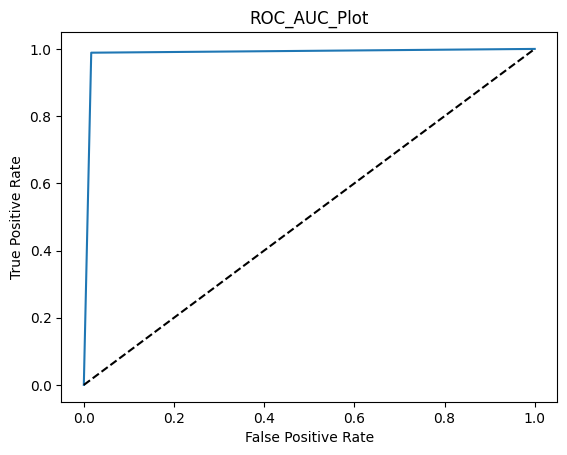

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       974
           1       0.96      0.99      0.98       445

    accuracy                           0.99      1419
   macro avg       0.98      0.99      0.98      1419
weighted avg       0.99      0.99      0.99      1419

Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9955 - loss: 0.0208
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9950 - loss: 0.0166
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9929 - loss: 0.0208
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9953 - loss: 0.0143
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0104
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - loss: 0.0147
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0101
Epoch 8/10
142/142 ━━━━━━━━━━━━━

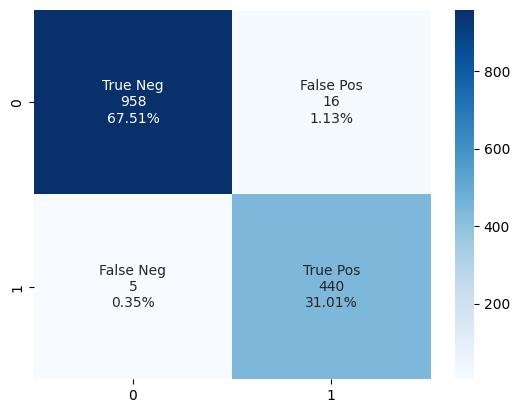

In [32]:
classifier_cnn = classifiers['CNN']
classifier_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("CNN")
model(classifier_cnn, X_train, y_train, X_test, y_test)
model_evaluation(classifier_cnn, X_test, y_test)
cross_validation_score(classifier_cnn, X_train, y_train)
print("\n")

### 7. RNN: 
- a recurrent neural network model designed for sequence data.

RNN
Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8636 - loss: 0.4212
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9334 - loss: 0.2055
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9395 - loss: 0.1987
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9449 - loss: 0.1845
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9476 - loss: 0.1747
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9502 - loss: 0.1651
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9474 - loss: 0.1718
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9495 - loss: 0.1659
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9500 - loss: 0.1575
Epoch 10/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9478 - loss: 0.1613
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
ROC_AUC Score :  93.52%


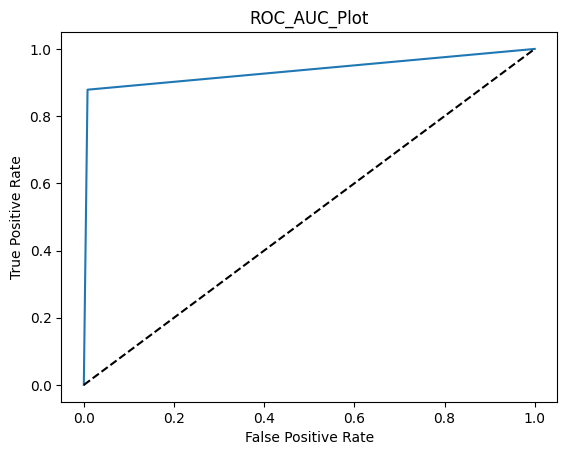

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       974
           1       0.98      0.88      0.93       445

    accuracy                           0.96      1419
   macro avg       0.96      0.94      0.95      1419
weighted avg       0.96      0.96      0.96      1419

Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9583 - loss: 0.1359
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9502 - loss: 0.1461
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9533 - loss: 0.1426
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9549 - loss: 0.1408
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9605 - loss: 0.1314
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9563 - loss: 0.1300
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9550 - loss: 0.1307
Epoch 8/10
142/142 ━━━━━━━━━━━

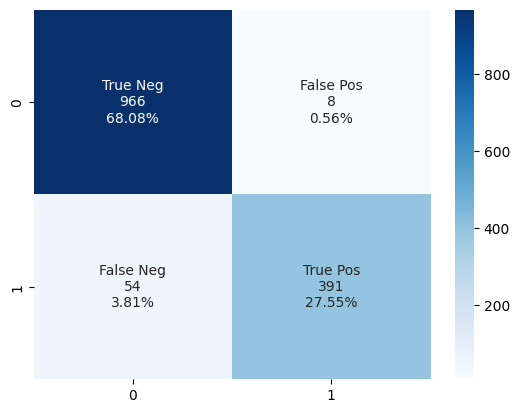

In [33]:
classifier_rnn = classifiers['RNN']
classifier_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("RNN")
model(classifier_rnn, X_train, y_train, X_test, y_test)
model_evaluation(classifier_rnn, X_test, y_test)
cross_validation_score(classifier_rnn, X_train, y_train)
print("\n")

### 8. LSTM: 
- a long short-term memory model designed for sequence data.

LSTM
Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8814 - loss: 0.4208
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9337 - loss: 0.2034
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9402 - loss: 0.1945
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9430 - loss: 0.1823
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9438 - loss: 0.1779
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9448 - loss: 0.1783
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9475 - loss: 0.1610
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9531 - loss: 0.1475
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9505 - loss: 0.1547
Epoch 10/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9541 - loss: 0.1418
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
ROC_AUC Score :  93.33%


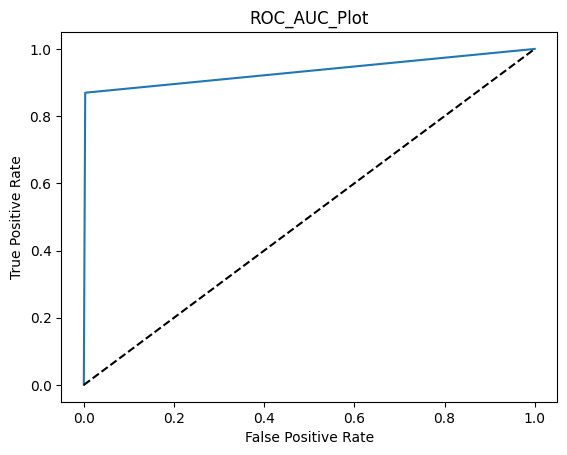

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       974
           1       0.99      0.87      0.93       445

    accuracy                           0.96      1419
   macro avg       0.97      0.93      0.95      1419
weighted avg       0.96      0.96      0.96      1419

Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9533 - loss: 0.1473
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9519 - loss: 0.1460
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9478 - loss: 0.1551
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9557 - loss: 0.1384
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9535 - loss: 0.1376
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9529 - loss: 0.1407
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9502 - loss: 0.1424
Epoch 8/10
142/142 ━━━━━━━━━━━

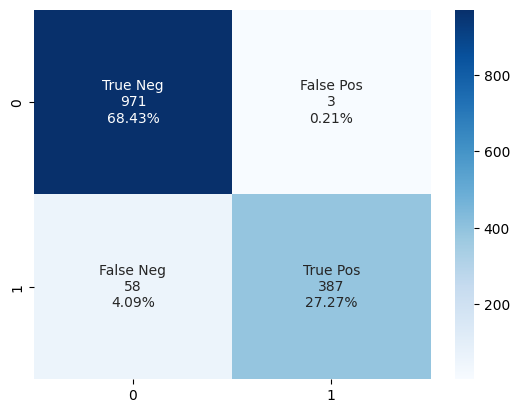

In [34]:
classifier_lstm = classifiers['LSTM']
classifier_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("LSTM")
model(classifier_lstm, X_train, y_train, X_test, y_test)
model_evaluation(classifier_lstm, X_test, y_test)
cross_validation_score(classifier_lstm, X_train, y_train)
print("\n")